## Declaraciones de las funciones y objetos utilizados

In [1]:
from sympy import symbols, Matrix, pprint, Eq, init_printing, zeros
from numpy import linspace, meshgrid
init_printing(use_latex=True)

Los __simbolos__ se declaran con la función `symbol()`. 

In [2]:
x_1, x_2, x_3 = symbols('x_1, x_2, x_3')
y_1, y_2, y_3 = symbols('y_1, y_2, y_3')
b_1, b_2, b_3 = symbols('b_1, b_2, b_3')
c_1, c_2, c_3 = symbols('c_1, c_2, c_3')
A, k = symbols('A, k')

Declaramos los vectores que contienen las variables anteriores usando `Matrix` y los guardamos en el diccionario del elemento modelo `e_mod`:

In [3]:
e_mod = {}
e_mod['x'] = Matrix([x_1, x_2, x_3])
e_mod['y'] = Matrix([y_1, y_2, y_3])
e_mod['b'] = Matrix([b_1, b_2, b_3])
e_mod['c'] = Matrix([c_1, c_2, c_3])
e_mod['A'] = A

Substituyendo los valores de _b<sub>i</sub>_ y _c<sub>i</sub>_.

In [4]:
e_mod['b'] = e_mod['b'].subs(b_1, e_mod['y'][1]-e_mod['y'][2])
e_mod['b'] = e_mod['b'].subs(b_2, e_mod['y'][2]-e_mod['y'][0])
e_mod['b'] = e_mod['b'].subs(b_3, e_mod['y'][0]-e_mod['y'][1])
e_mod['c'] = e_mod['c'].subs(c_1, e_mod['x'][2]-e_mod['x'][1])
e_mod['c'] = e_mod['c'].subs(c_2, e_mod['x'][0]-e_mod['x'][2])
e_mod['c'] = e_mod['c'].subs(c_3, e_mod['x'][1]-e_mod['x'][0])

Construimos la matriz `Ke` del elemento.

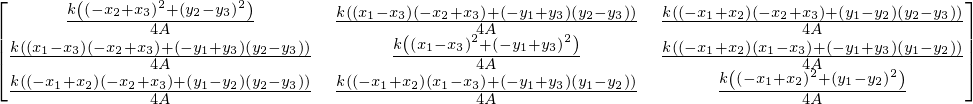

In [5]:
K_e = zeros(3,3)
for i in range(0,3):
    for j in range(0,3):
        K_e[i,j] = e_mod['b'][i]*e_mod['b'][j]+e_mod['c'][i]*e_mod['c'][j]
e_mod['K'] = k / 4 / e_mod['A'] * K_e
e_mod['F'] = Matrix([0,0,0])
e_mod['K']

A continuación creamos las coordenadas para una malla regular. `div` es el número de nodos en __x__ y en __y__.

In [6]:
div = 3

xx = linspace(0,0.1,div)
yy = linspace(0,0.1,div)

dx = xx[1] - xx[0]
dy = yy[1] - yy[0]

El elemento modelo es copiado en con el siguiente ciclo `for`, ya con las coordenadas de cada elemento substituidas.

In [7]:
elementos = []

for j, y in enumerate(yy[:-1]):
    for i, x in enumerate(xx[:-1]):
        var = {'x_1': x, 'x_2': x, 'x_3': x+dx,
               'y_1': y, 'y_2': y+dy, 'y_3': y,
               'A': dx*dy/2, 'k': 50.0}
        e1 = {'n':[i+j*div,i+(j+1)*div,i+1+j*div]}
        for ee in e_mod:
            e1[ee] = e_mod[ee].subs(var)
        elementos.append(e1)
        
        var = {'x_1': x, 'x_2': x+dx, 'x_3': x+dx,
               'y_1': y+dx, 'y_2': y+dy, 'y_3': y,
               'A': dx*dy/2, 'k': 50.0}
        e2 = {'n':[i+(j+1)*div,i+1+(j+1)*div,i+1+j*div]}
        for ee in e_mod:
            e2[ee] = e_mod[ee].subs(var)    
        elementos.append(e2)

n = i+1+(j+1)*div

Modificamos ahora los elemntos con generación (en este ejemplo ningúno).

In [8]:
Q = 0
for e in elementos:
    F = Q * e['A']/3 * Matrix([1,1,1])
    e.update({'F':F})

Vector fuerza, aplicado en los nodos de los elementos con flujo de calor.

In [9]:
F1 = 10000 * dy / 2 * Matrix([1,1,0])
for e in elementos:
    if e['x'][1] == 0:
        e['F'] = e['F'] + F1

Ensamblamos la matriz __K__  y el vector __F__ del sistema utilizando la información de los nodos. 

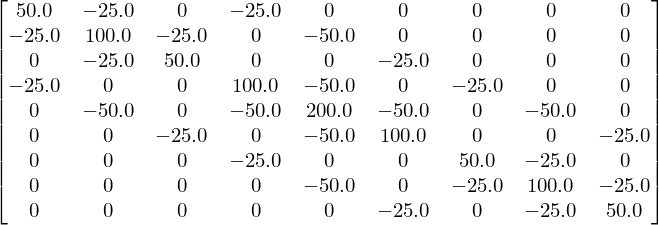

In [10]:
K = zeros(n+1,n+1)
F = zeros(n+1,1)
for e in elementos:
    for i, j in enumerate(e['n']):
        for k, m in enumerate(e['n']):
            #print(j,m)
            K[j,m] = K[j,m] + e['K'][i,k]
        F[j] = F[j] + e['F'][i]
        
K

Finalmente construimos un vector con las temperaturas conocidas.

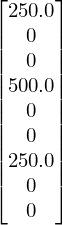

In [11]:
F

Construimos un vector con la temperatura conocida para los nodos que tienen dicha condición. Las temperaturas incógnita se colocan como `None`.

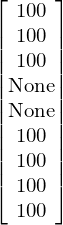

In [12]:
Tf = Matrix([None] * int(n+1))
for i, e in enumerate(elementos):
    for x, y, nn in zip(e['x'],e['y'],e['n']):
        if x > 0.09999:
            Tf[nn]= 100
        if y > 0.09999:
            Tf[nn]= 100
        if y < 0.00001:
            Tf[nn]= 100
Tf

Y modificamos la matriz K, para quitar dichas incognitas.

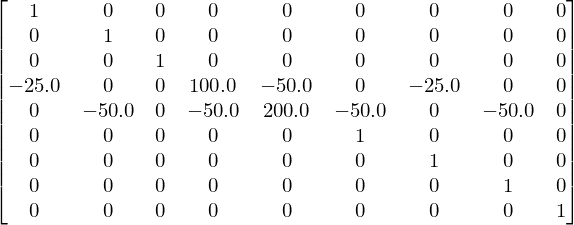

In [13]:
for i, t in enumerate(Tf):
    if t is not None:
        for j in range(n+1):
            K[i,j] = 0
            if i == j:
                K[i,j] = 1
            F[i] = t
K

El sistema se resuelve utilizando el método `LUsolve()`.

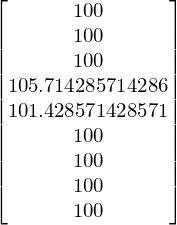

In [14]:
T = K.LUsolve(F)
T

Para graficar el sistema utilizamos la librería __matplotlib__.

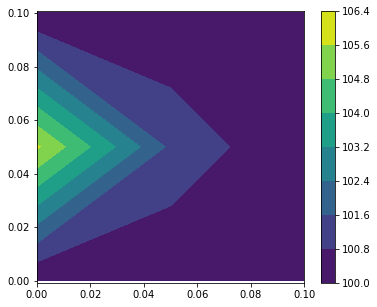

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

xc, yc = meshgrid(xx,yy)

plt.figure(figsize=(6,5))

cs = plt.contourf(xc,yc,T.reshape(xc.shape[0], xc.shape[1]))
plt.axis('equal')

plt.colorbar(cs)
plt.axis('equal')
plt.show()